In [1]:
from urllib.request import urlopen
from bs4 import BeautifulSoup
import re
from selenium import webdriver
from selenium.webdriver.common.keys import Keys

import time
from collections import defaultdict
import numpy as np
import pandas as pd
import pickle

import geopandas as gpd
import descartes

import geopy
# import Nominatim
from geopy.geocoders import Nominatim
from shapely.ops import cascaded_union
from shapely.geometry.polygon import Polygon
from shapely.geometry import Point
# import adjustText as aT
import matplotlib.pyplot as plt
import difflib
# from Levenshtein import distance as levenshtein_distance

In c:\programdata\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In c:\programdata\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In c:\programdata\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In c:\programdata\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In c:\programdata\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mpl

In [2]:
# Loading saved data

with open('grounds_dict.pickle', 'rb') as handle:
    grounds_dict = pickle.load(handle)

with open('address_dict.pickle', 'rb') as handle:
    address_dict = pickle.load(handle)

with open('cities_id_dict.pickle', 'rb') as handle:
    cities_id_dict = pickle.load(handle)

In [3]:
grounds_dict

{'num_stads': {'Agartala': 3,
  'Agra': 2,
  'Ahmedabad': 7,
  'Ahmednagar': 1,
  'Ajmer': 1,
  'Akola': 1,
  'Aligarh': 1,
  'Allahabad': 2,
  'Alwar': 1,
  'Amravati': 2,
  'Amritsar': 1,
  'Anand': 1,
  'Anantapur': 3,
  'Angul': 1,
  'Asansol': 1,
  'Atul': 1,
  'Aurangabad': 5,
  'Balangir': 1,
  'Balasore': 1,
  'Balurghat': 1,
  'Bareilly': 2,
  'Baripada': 1,
  'Beawar': 1,
  'Belgaum': 2,
  'Bellary': 1,
  'Bengaluru': 21,
  'Berhampur': 2,
  'Bhadravati': 1,
  'Bhagalpur': 2,
  'Bharuch': 2,
  'Bhavnagar': 3,
  'Bheemavaram': 1,
  'Bhilai': 2,
  'Bhilwara': 3,
  'Bhinmal': 1,
  'Bhiwani': 2,
  'Bhopal': 2,
  'Bhubaneswar': 3,
  'Bhuj': 1,
  'Bhusawal': 1,
  'Bidar': 1,
  'Bijapur': 1,
  'Bikaner': 1,
  'Bilaspur': 1,
  'Birsingpur': 1,
  'Burnpur': 1,
  'Chamba': 1,
  'Chandigarh': 5,
  'Chennai': 18,
  'Coimbatore': 5,
  'Cuddapah': 2,
  'Cuttack': 6,
  'Davanagere': 1,
  'Dehra Dun': 6,
  'Delhi': 13,
  'Dhanbad': 3,
  'Dharamsala': 0,
  'Dharwar': 3,
  'Dhrol': 1,
  'Dibru

In [4]:
address_dict['district'].values()

dict_values(['West Tripura', 'Agra', 'Ahmedabad District', 'Ahmednagar', 'Ajmer', 'Akola', 'Aligarh', 'Prayagraj', 'Alwar', 'Amravati', 'Amritsar', 'Anand District', 'Anantapur', 'Anugul', 'Paschim Bardhaman', 'Valsad', 'Aurangabad', 'Balangir', 'Baleshwar', 'Dakshin Dinajpur', 'Bareilly', 'Mayurbhanj', 'Ajmer', 'Belgaum district', 'Bellary district', 'Bangalore Urban', 'Baleshwar', 'Chandrapur District', 'Bhagalpur', 'Bharuch District', 'Bhavnagar District', 'Krishna', 'Durg', 'Bhilwara', 'Jalor', 'Bhiwani district', 'Bhopal', 'Khordha', 'Kutch District', 'Jalgaon', 'Bidar district', 'Bijapur Tahsil', 'Bikaner', 'Rampur', 'Buldhana', 'Paschim Bardhaman', 'Chamba district', 'Chandigarh', 'Chennai District', 'Coimbatore District', 'YSR', 'Cuttack', 'Davanagere district', 'Dehradun', 'West Delhi', 'Dhanbad', 'Kangra', 'Dharwad district', 'Jamnagar District', 'Dibrugarh', 'Dimapur', 'Dindgul District', 'Durg', 'West Godavari', 'Ernakulam district', 'Erode District', 'Faridabad', 'Fategarh

In [5]:
len(grounds_dict['num_stads']) == len(address_dict['district'])

True

## Reading India shapefiles

In [6]:
fp = "maps/output.shp"

map_df = gpd.read_file(fp)
map_df = map_df.astype({'objectid':str})

**Combining all districts of Delhi into a single district**

In [7]:
if('Delhi' not in list(map_df['statename'])):
    map_df.loc[len(map_df.index)] = ['-1','07', 'Delhi', '', '', 'Delhi', \
                                 map_df[map_df['statename'] == 'NCT of Delhi']['distarea'].sum(), \
                                map_df[map_df['statename'] == 'NCT of Delhi']['totalpopul'].sum(), \
                                     '', '', '', '', '', cascaded_union(list(map_df[map_df['statename'] == 'NCT of Delhi']['geometry'].values))]
    map_df = map_df.drop(map_df[map_df['statename'] == 'NCT of Delhi'].index).reset_index(drop = True)
else:
    pass    

In [8]:
map_df

,objectid,statecode,statename,state_ut,distcode,distname,distarea,totalpopul,totalhh,totpopmale,totpopfema,st_areasha,st_lengths,geometry
0,1,05,Uttarakhand,STATE,066,Nainital,4251.0,954605.0,191383.0,493666.0,460939.0,5322546064.569777,506182.695952,"POLYGON ((79.52659 29.05543, 79.52550 29.05545..."
1,2,05,Uttarakhand,STATE,060,Dehradun,3088.0,1696694.0,347001.0,892199.0,804495.0,4177235501.658399,578188.681639,"POLYGON ((77.87557 30.26052, 77.87467 30.26087..."
2,3,05,Uttarakhand,STATE,064,Almora,3144.0,622506.0,140577.0,291081.0,331425.0,4140751140.840048,463454.225766,"POLYGON ((79.28494 29.92735, 79.28495 29.92723..."
3,4,05,Uttarakhand,STATE,065,Champawat,1766.0,259648.0,53953.0,131125.0,128523.0,2294297183.860695,314508.010612,"POLYGON ((80.12479 29.01308, 80.12481 29.01306..."
4,5,05,Uttarakhand,STATE,056,Uttarkashi,8016.0,330086.0,67602.0,168597.0,161489.0,10851662987.437235,786425.588972,"POLYGON ((78.92267 31.25333, 78.93106 31.26840..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
680,692,36,Telangana,STATE,T27,Vikarabad,NaN,927140.0,194956.0,463350.0,463790.0,3978808365.185194,372343.04832,"POLYGON ((77.41953 17.12279, 77.41852 17.12334..."
681,693,36,Telangana,STATE,T13,Mahabubnagar,NaN,1486777.0,300508.0,745101.0,741676.0,5627610451.60645,442067.957315,"POLYGON ((77.49606 16.38155, 77.49382 16.38188..."
682,41,01,Ladakh,STATE,004,Kargil,14036.0,140802.0,18338.0,77785.0,63017.0,21526165823.051476,1151337.470736,"POLYGON ((76.13869 34.63398, 76.13957 34.63408..."
683,34,01,Ladakh,STATE,003,Leh (Ladakh),45110.0,133487.0,21909.0,78971.0,54516.0,118114855262.338409,2283245.867302,"POLYGON ((80.06767 34.78624, 80.06849 34.77767..."


**Mapping districts (of the cities in cricinfo data) obtained using geopy to the districts in India shapefile**

In [9]:
district_map = {}

district_map['YSR'] = '148'
district_map['Prayagraj'] = '656'
district_map['Paschim Bardhaman'] = '171'
district_map['Bangalore Urban'] = '329'
district_map['Kutch District'] = '65'
district_map['Bijapur Tahsil'] = '513'
district_map['Kalaburagi district'] = '317'
district_map['Nagda'] = '84'

In [10]:
map_df[map_df['objectid'] == '-1']

,objectid,statecode,statename,state_ut,distcode,distname,distarea,totalpopul,totalhh,totpopmale,totpopfema,st_areasha,st_lengths,geometry
684,-1,07,Delhi,,,Delhi,1483.0,16787941.0,,,,,,"POLYGON ((77.30523 28.48746, 77.30511 28.48746..."


In [11]:
for city in address_dict['district']:
    dist = address_dict['district'][city]
    if(dist not in district_map):
        search_dist = difflib.get_close_matches(re.split(' District| district|District|district',dist)[0], \
                                                           list(map_df['distname']))[0]
        district_map[dist] = str(map_df[map_df['distname'] == search_dist]['objectid'].values[0])

In [12]:
district_map

{'YSR': '148',
 'Prayagraj': '656',
 'Paschim Bardhaman': '171',
 'Bangalore Urban': '329',
 'Kutch District': '65',
 'Bijapur Tahsil': '513',
 'Kalaburagi district': '317',
 'Nagda': '84',
 'West Tripura': '450',
 'Agra': '635',
 'Ahmedabad District': '61',
 'Ahmednagar': '332',
 'Ajmer': '541',
 'Akola': '340',
 'Aligarh': '578',
 'Alwar': '659',
 'Amravati': '350',
 'Amritsar': '287',
 'Anand District': '46',
 'Anantapur': '146',
 'Anugul': '466',
 'Valsad': '90',
 'Aurangabad': '218',
 'Balangir': '494',
 'Baleshwar': '478',
 'Dakshin Dinajpur': '167',
 'Bareilly': '584',
 'Mayurbhanj': '476',
 'Belgaum district': '327',
 'Bellary district': '323',
 'Chandrapur District': '339',
 'Bhagalpur': '210',
 'Bharuch District': '69',
 'Bhavnagar District': '60',
 'Krishna': '135',
 'Durg': '511',
 'Bhilwara': '534',
 'Jalor': '546',
 'Bhiwani district': '251',
 'Bhopal': '126',
 'Khordha': '475',
 'Jalgaon': '357',
 'Bidar district': '315',
 'Bikaner': '531',
 'Rampur': '583',
 'Buldhana':

In [13]:
final_list = []

for city in address_dict['district']:
    dist = address_dict['district'][city]
    dist_id = district_map[dist]
    if(len(map_df[map_df['objectid'] == dist_id]['distarea'].values) > 1):
        print(dist_id)
    new_dist = map_df[map_df['objectid'] == dist_id]['distname'].values[0]
    area = map_df[map_df['objectid'] == dist_id]['distarea'].values[0]
    pop = map_df[map_df['objectid'] == dist_id]['totalpopul'].values[0]
    geom = map_df[map_df['objectid'] == dist_id]['geometry'].values[0]
    num_stads = grounds_dict['num_stads'][city]
    state = map_df[map_df['objectid'] == dist_id]['statename'].values[0]
    final_list.append([city, new_dist, dist_id, num_stads, area, pop, geom, state])

In [14]:
for objectid in map_df['objectid']:
    if(objectid not in district_map.values()):
#         dist = address_dict['district'][city]
#         dist_id = district_map[dist]
#         if(len(map_df[map_df['objectid'] == dist_id]['distarea'].values) > 1):
#             print(dist_id)
        new_dist = map_df[map_df['objectid'] == objectid]['distname'].values[0]
        area = map_df[map_df['objectid'] == objectid]['distarea'].values[0]
        pop = map_df[map_df['objectid'] == objectid]['totalpopul'].values[0]
        geom = map_df[map_df['objectid'] == objectid]['geometry'].values[0]
        state = map_df[map_df['objectid'] == objectid]['statename'].values[0]
        num_stads = 0
        final_list.append(['', new_dist, objectid, num_stads, area, pop, geom, state])

In [15]:
final_df = pd.DataFrame(final_list, columns=['City', 'District', 'objectid', 'Num Stads', 'Area', \
                                             'Population', 'Geometry', 'State'])

In [16]:
# Final DF of all districts present in shape file with required columns

final_df

,City,District,objectid,Num Stads,Area,Population,Geometry,State
0,Agartala,West Tripura,450,3,2993.0,1725739.0,"POLYGON ((91.37576999961117 24.10808999991291,...",Tripura
1,Agra,Agra,635,2,4041.0,4418797.0,"POLYGON ((77.87337000039358 26.90195999982702,...",Uttar Pradesh
2,Ahmedabad,Ahmadabad,61,7,8107.0,7214225.0,"(POLYGON ((72.03559000006261 23.5032400002783,...",Gujarat
3,Ahmednagar,Ahmadnagar,332,1,17048.0,4543159.0,"POLYGON ((74.74069999970516 18.39800999978702,...",Maharashtra
4,Ajmer,Ajmer,541,1,8481.0,2583052.0,(POLYGON ((74.90437000008124 26.97548000011174...,Rajasthan
...,...,...,...,...,...,...,...,...
715,,Wanaparthy,691,0,NaN,577758.0,"POLYGON ((78.23114514126235 16.43789457103552,...",Telangana
716,,Vikarabad,692,0,NaN,927140.0,"POLYGON ((77.41953000040813 17.12278999976213,...",Telangana
717,,Mahabubnagar,693,0,NaN,1486777.0,"POLYGON ((77.49606000013496 16.38155000017794,...",Telangana
718,,Kargil,41,0,14036.0,140802.0,"POLYGON ((76.13869000029725 34.63398000018494,...",Ladakh


In [17]:
# final_df.to_csv('final_df.csv', index = False)

In [18]:
# Grouping data based on each District using 'objectid' which is unique for each District

final_df_grouped= final_df.groupby('objectid').agg({'City':lambda x: list(x), 'District':lambda x: np.unique(list(x)),\
                                  'Num Stads':lambda x: sum(x), 'Area':lambda x: x.sum(skipna=True), \
                                  'Population':lambda x: x.sum(skipna=True), 'Geometry':lambda x: list(x)[0], \
                                                   'State': lambda x: np.unique(list(x))}).reset_index()

In [19]:
final_df_grouped['StadsPerPop'] = final_df_grouped['Num Stads']/final_df_grouped['Population']
final_df_grouped['StadsPerArea'] = final_df_grouped['Num Stads']/final_df_grouped['Area']

In [20]:
final_df_grouped

,objectid,City,District,Num Stads,Area,Population,Geometry,State,StadsPerPop,StadsPerArea
0,-1,[Delhi],Delhi,13,1483.0,16787941.0,"POLYGON ((77.30523000038721 28.48746000022276,...",Delhi,7.743654e-07,0.008766
1,1,[],Nainital,0,4251.0,954605.0,"POLYGON ((79.52658999977145 29.05542999993833,...",Uttarakhand,0.000000e+00,0.000000
2,10,[],Bageshwar,0,2241.0,259898.0,"POLYGON ((79.70261000004604 29.79050000023519,...",Uttarakhand,0.000000e+00,0.000000
3,100,[],Satna,0,7502.0,2228935.0,"POLYGON ((80.99521000005157 24.08858999981634,...",Madhya Pradesh,0.000000e+00,0.000000
4,101,[],Chhatarpur,0,8687.0,1762375.0,"POLYGON ((79.33391999969186 24.99718999989129,...",Madhya Pradesh,0.000000e+00,0.000000
...,...,...,...,...,...,...,...,...,...,...
680,95,[],Dadra & Nagar Haveli,0,491.0,343709.0,"POLYGON ((73.19206999994937 20.19872999975748,...",Dadra & Nagar Haveli,0.000000e+00,0.000000
681,96,[],Ashoknagar,0,4674.0,845071.0,"POLYGON ((77.69806999981921 24.85585999989527,...",Madhya Pradesh,0.000000e+00,0.000000
682,97,[],Raisen,0,8466.0,1331597.0,"POLYGON ((77.44709999985862 22.90591000030355,...",Madhya Pradesh,0.000000e+00,0.000000
683,98,[],Chhindwara,0,11815.0,2090922.0,"POLYGON ((78.43637000024435 21.50086999965938,...",Madhya Pradesh,0.000000e+00,0.000000


In [21]:
# Converting the grouped dataframe to geo Dataframe

final_df_geop = gpd.GeoDataFrame(final_df_grouped, geometry = final_df_grouped['Geometry'])

In [22]:
# final_df_geop.to_csv('final_df_geop.csv')

In [23]:
final_df_geop_million = final_df_geop
final_df_geop_million['StadsPerPop'] = final_df_geop['StadsPerPop']*1000000
final_df_geop_million['StadsPerArea'] = final_df_geop['StadsPerArea']*1000000

## Plotting using shapefile

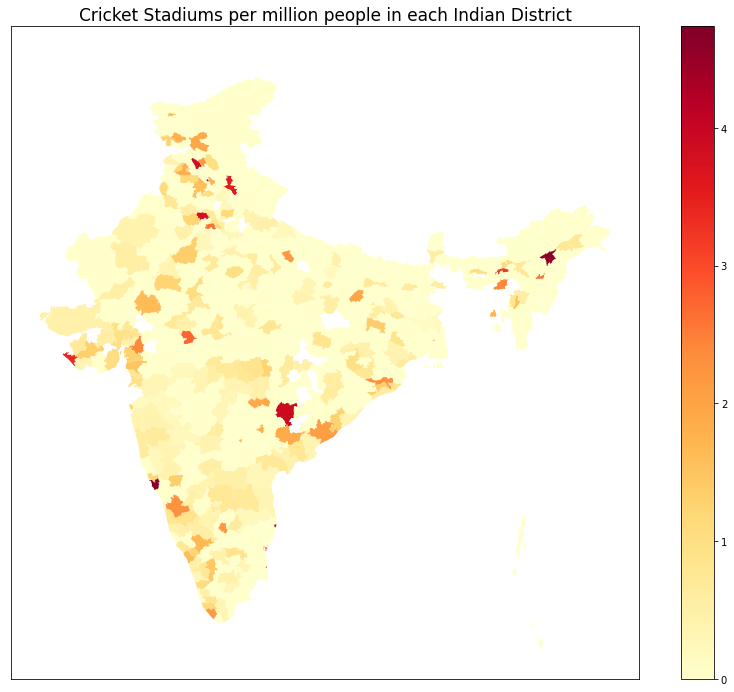

In [36]:
plt.style.use('tableau-colorblind10')

fig, ax1 = plt.subplots(figsize=(15,12))
ax1.set_title('Cricket Stadiums per million people in each Indian District', fontdict={'fontsize': '17', 'fontweight' : '3'})
# ax1.set_xlabel('Longitude')
# ax1.set_ylabel('Latitude')
plt.xticks([])
plt.yticks([])

final_df_geop.plot(column='StadsPerPop', cmap='YlOrRd', linewidth=0.8, ax = ax1, legend=True, missing_kwds={'color': 'white'})

# fig.savefig('plots/Num of Stads Per Pop District.png', dpi = 1000, edgecolor='white', facecolor = 'white')

plt.show();

In [25]:
final_df_geop_million.sort_values('StadsPerPop', ascending=False)

,objectid,City,District,Num Stads,Area,Population,Geometry,State,StadsPerPop,StadsPerArea,geometry
186,272,[Chandigarh],Chandigarh,5,114.0,1055450.0,"POLYGON ((76.74940000009637 30.68751999989869,...",Chandigarh,4.737316,43859.649123,"POLYGON ((76.74940 30.68752, 76.74758 30.68969..."
302,379,"[Margao, Vasco da Gama]",South Goa,6,3932.0,1281074.0,(POLYGON ((74.25319000021385 15.48918999973073...,Goa,4.683570,1525.940997,"MULTIPOLYGON (((74.25319 15.48919, 74.26439 15..."
378,447,[Jorhat],Jorhat,5,2851.0,1092256.0,"POLYGON ((94.54273999999231 27.22254000016725,...",Assam,4.577681,1753.770607,"POLYGON ((94.54274 27.22254, 94.54291 27.22264..."
452,513,[Bijapur],Bijapur,1,8530.0,255230.0,"POLYGON ((80.30397000019478 18.69090999975712,...",Chhatisgarh,3.918035,117.233294,"POLYGON ((80.30397 18.69091, 80.30330 18.69176..."
602,649,[Chennai],Chennai,18,175.0,4646732.0,"POLYGON ((80.19461000031292 13.09256999985005,...",Tamil Nadu,3.873690,102857.142857,"POLYGON ((80.19461 13.09257, 80.19464 13.09312..."
...,...,...,...,...,...,...,...,...,...,...,...
581,63,[],Batod,0,0.0,0.0,"POLYGON ((71.83839999996852 22.35963999978125,...",Gujarat,NaN,NaN,"POLYGON ((71.83840 22.35964, 71.83874 22.36020..."
653,70,[],Gir Somnath,0,0.0,0.0,(POLYGON ((70.59017999995038 21.28377000038759...,Gujarat,NaN,NaN,"MULTIPOLYGON (((70.59018 21.28377, 70.59215 21..."
655,72,[],Devbhumi Dwarka,0,0.0,0.0,(POLYGON ((69.07927000025997 22.47856999989934...,Gujarat,NaN,NaN,"MULTIPOLYGON (((69.07927 22.47857, 69.08142 22..."
677,92,[],Mahisagar,0,0.0,0.0,"POLYGON ((73.43805000044048 23.27527000021491,...",Gujarat,NaN,NaN,"POLYGON ((73.43805 23.27527, 73.44213 23.27725..."


In [26]:
final_df_geop_million[final_df_geop_million['District'] == 'Chennai']

,objectid,City,District,Num Stads,Area,Population,Geometry,State,StadsPerPop,StadsPerArea,geometry
602,649,[Chennai],Chennai,18,175.0,4646732.0,"POLYGON ((80.19461000031292 13.09256999985005,...",Tamil Nadu,3.87369,102857.142857,"POLYGON ((80.19461 13.09257, 80.19464 13.09312..."


## Grouping by State

In [27]:
final_df_grouped_st= final_df_grouped.groupby('State').agg({'District':lambda x: list(x), \
                                                    'Num Stads':lambda x: sum(x), \
                                                       'Area':lambda x: x.sum(skipna=True), \
                                                            'Population':lambda x: x.sum(skipna=True), \
                                                       'Geometry':lambda x: \
                                                    cascaded_union(list(x))}).reset_index()

final_df_grouped_st['StadsPerPop'] = final_df_grouped_st['Num Stads']/final_df_grouped_st['Population']
final_df_grouped_st['StadsPerArea'] = final_df_grouped_st['Num Stads']/final_df_grouped_st['Area']

In [28]:
final_df_geop_st = gpd.GeoDataFrame(final_df_grouped_st, geometry = final_df_grouped_st['Geometry'])

In [29]:
final_df_geop_st['StadsPerPop'] = final_df_geop_st['StadsPerPop']*1000000

In [30]:
final_df_geop_st.sort_values('Num Stads', ascending = False)

,State,District,Num Stads,Area,Population,Geometry,StadsPerPop,StadsPerArea,geometry
11,Gujarat,"[Sabar Kantha, Banas Kantha, Surendranagar, An...",61,283739.0,73664364.0,(POLYGON ((72.99865000003233 20.23751000006123...,0.828080,0.000215,"MULTIPOLYGON (((72.99865 20.23751, 72.99881 20..."
21,Maharashtra,"[Washim, Ahmadnagar, Latur, Solapur, Nashik, O...",56,387911.0,147860898.0,(POLYGON ((73.41400000002349 15.89147000039262...,0.378734,0.000144,"MULTIPOLYGON (((73.41400 15.89147, 73.40467 15..."
16,Karnataka,"[Mandya, Mysore, Chikkaballapura, Yadgir, Chik...",50,199633.0,64119681.0,(POLYGON ((77.47366000007898 12.24577999993627...,0.779792,0.000250,"MULTIPOLYGON (((77.47366 12.24578, 77.47750 12..."
34,Uttar Pradesh,"[Moradabad, Sambhal, Budaun, Kanshiram Nagar, ...",47,243642.0,208170827.0,"POLYGON ((78.17310999976139 24.84318999967221,...",0.225776,0.000193,"POLYGON ((78.17311 24.84319, 78.17301 24.84323..."
1,Andhra Pradesh,"[Prakasam, Krishna, East Godavari, Visakhapatn...",43,197777.0,67826806.0,(POLYGON ((78.55344000035963 13.19348999963963...,0.633968,0.000217,"MULTIPOLYGON (((78.55344 13.19349, 78.55335 13..."
17,Kerala,"[Kannur, Pathanamthitta, Alappuzha, Ernakulam,...",34,44876.0,39211452.0,"POLYGON ((76.68152999955865 8.764179999625092,...",0.867094,0.000758,"POLYGON ((76.68153 8.76418, 76.68127 8.76463, ..."
31,Tamil Nadu,"[Ariyalur, Sivaganga, Thanjavur, Tiruvannamala...",31,130060.0,72147030.0,(POLYGON ((77.55640000036433 8.078090000014718...,0.429678,0.000238,"MULTIPOLYGON (((77.55640 8.07809, 77.55640 8.0..."
29,Rajasthan,"[Jhunjhunun, Jaisalmer, Sikar, Hanumangarh, Na...",29,350720.0,71131489.0,"POLYGON ((74.59991999982982 23.43004000022106,...",0.407696,0.000083,"POLYGON ((74.59992 23.43004, 74.59988 23.42998..."
26,Orissa,"[Subarnapur, Puri, Anugul, Debagarh, Koraput, ...",21,165888.0,45568568.0,(POLYGON ((85.49478000015318 19.52033999990278...,0.460844,0.000127,"MULTIPOLYGON (((85.49478 19.52034, 85.49223 19..."
20,Madhya Pradesh,"[Satna, Chhatarpur, Indore, Ratlam, Harda, Sag...",21,314343.0,74613673.0,"POLYGON ((76.70157999964485 21.38651999973315,...",0.281450,0.000067,"POLYGON ((76.70158 21.38652, 76.70130 21.38635..."


In [31]:
final_df_geop_st["center"] = final_df_geop_st["geometry"].centroid
final_df_geop_st_points = final_df_geop_st.copy()
final_df_geop_st_points.set_geometry("center", inplace = True)

c:\programdata\anaconda3\lib\site-packages\geopandas\plotting.py:376: UserWarning: The GeoSeries you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,


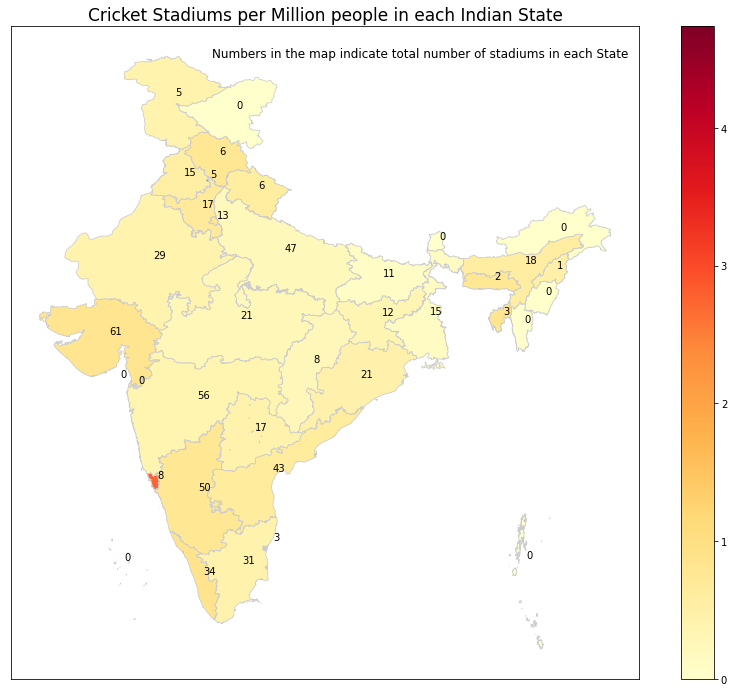

In [35]:
ax = final_df_geop_st.plot(figsize = (15, 12), column='StadsPerPop', cmap='YlOrRd', linewidth=0.8, edgecolor='0.8', legend=True, missing_kwds={'color': 'lightgrey'})
ax.set_title('Cricket Stadiums per Million people in each Indian State', fontdict={'fontsize': '17', 'fontweight' : '3'})
# ax1.set_xlabel('Longitude')
# ax1.set_ylabel('Latitude')
plt.xticks([])
plt.yticks([])

for x, y, label in zip(final_df_geop_st_points.geometry.x, final_df_geop_st_points.geometry.y, final_df_geop_st_points['Num Stads']):
    ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points")

ax.annotate('Numbers in the map indicate total number of stadiums in each State', xy=(77, 37)).set_fontsize(12)

# plt.savefig('plots/Num of Stads Per Pop State.png', dpi = 1000, facecolor='white', edgecolor='white')

plt.show()
